In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms, datasets, models
from sklearn.model_selection import StratifiedKFold
from tqdm.notebook import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Define the path to your dataset
path = '/home/rishabh.mondal/R_P_project/Faulty_solar_panel'

# Define transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create the ImageFolder dataset
dataset = datasets.ImageFolder(root=path, transform=transform)

# Define the number of splits for cross-validation
n_splits = 4  # 4-fold cross-validation

# Initialize stratified k-fold cross-validation
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

Training Fold 1/4
3 1


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold: 1, Epoch 10/50, Train Loss: 0.0082, Train Accuracy: 0.9970, Val Loss: 0.5798, Val Accuracy: 0.8604, Precision: 0.8649, Recall: 0.8604, F1 Score: 0.8607
Fold: 1, Epoch 20/50, Train Loss: 0.0330, Train Accuracy: 0.9940, Val Loss: 0.6700, Val Accuracy: 0.8694, Precision: 0.8731, Recall: 0.8694, F1 Score: 0.8699
Fold: 1, Epoch 30/50, Train Loss: 0.0150, Train Accuracy: 0.9925, Val Loss: 0.7619, Val Accuracy: 0.8333, Precision: 0.8423, Recall: 0.8333, F1 Score: 0.8334
Fold: 1, Epoch 40/50, Train Loss: 0.0278, Train Accuracy: 0.9864, Val Loss: 0.7123, Val Accuracy: 0.8604, Precision: 0.8638, Recall: 0.8604, F1 Score: 0.8597
Fold: 1, Epoch 50/50, Train Loss: 0.0784, Train Accuracy: 0.9789, Val Loss: 0.8700, Val Accuracy: 0.8649, Precision: 0.8661, Recall: 0.8649, F1 Score: 0.8646
Training Fold 2/4
3 1


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold: 2, Epoch 10/50, Train Loss: 0.0287, Train Accuracy: 0.9970, Val Loss: 1.3256, Val Accuracy: 0.7873, Precision: 0.8185, Recall: 0.7873, F1 Score: 0.7877
Fold: 2, Epoch 20/50, Train Loss: 0.0234, Train Accuracy: 0.9940, Val Loss: 1.1451, Val Accuracy: 0.8100, Precision: 0.8268, Recall: 0.8100, F1 Score: 0.8096
Fold: 2, Epoch 30/50, Train Loss: 0.0190, Train Accuracy: 0.9970, Val Loss: 1.0895, Val Accuracy: 0.8145, Precision: 0.8274, Recall: 0.8145, F1 Score: 0.8138
Fold: 2, Epoch 40/50, Train Loss: 0.0146, Train Accuracy: 0.9955, Val Loss: 0.8762, Val Accuracy: 0.8371, Precision: 0.8389, Recall: 0.8371, F1 Score: 0.8356
Fold: 2, Epoch 50/50, Train Loss: 0.0104, Train Accuracy: 0.9925, Val Loss: 0.8819, Val Accuracy: 0.8281, Precision: 0.8319, Recall: 0.8281, F1 Score: 0.8285
Training Fold 3/4
3 1


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold: 3, Epoch 10/50, Train Loss: 0.0079, Train Accuracy: 0.9970, Val Loss: 1.4200, Val Accuracy: 0.7783, Precision: 0.8198, Recall: 0.7783, F1 Score: 0.7801
Fold: 3, Epoch 20/50, Train Loss: 0.0170, Train Accuracy: 0.9970, Val Loss: 0.9898, Val Accuracy: 0.8462, Precision: 0.8513, Recall: 0.8462, F1 Score: 0.8476
Fold: 3, Epoch 30/50, Train Loss: 0.0427, Train Accuracy: 0.9834, Val Loss: 0.8604, Val Accuracy: 0.8552, Precision: 0.8584, Recall: 0.8552, F1 Score: 0.8547
Fold: 3, Epoch 40/50, Train Loss: 0.0249, Train Accuracy: 0.9925, Val Loss: 0.8761, Val Accuracy: 0.8688, Precision: 0.8724, Recall: 0.8688, F1 Score: 0.8692
Fold: 3, Epoch 50/50, Train Loss: 0.0091, Train Accuracy: 0.9955, Val Loss: 0.8787, Val Accuracy: 0.8597, Precision: 0.8675, Recall: 0.8597, F1 Score: 0.8609
Training Fold 4/4
3 1


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold: 4, Epoch 10/50, Train Loss: 0.0150, Train Accuracy: 0.9955, Val Loss: 0.9817, Val Accuracy: 0.8371, Precision: 0.8536, Recall: 0.8371, F1 Score: 0.8361
Fold: 4, Epoch 20/50, Train Loss: 0.0126, Train Accuracy: 0.9970, Val Loss: 0.8303, Val Accuracy: 0.8733, Precision: 0.8753, Recall: 0.8733, F1 Score: 0.8720
Fold: 4, Epoch 30/50, Train Loss: 0.0552, Train Accuracy: 0.9849, Val Loss: 0.7667, Val Accuracy: 0.8597, Precision: 0.8628, Recall: 0.8597, F1 Score: 0.8581
Fold: 4, Epoch 40/50, Train Loss: 0.0114, Train Accuracy: 0.9970, Val Loss: 0.8117, Val Accuracy: 0.8371, Precision: 0.8405, Recall: 0.8371, F1 Score: 0.8361
Fold: 4, Epoch 50/50, Train Loss: 0.0070, Train Accuracy: 0.9955, Val Loss: 0.8341, Val Accuracy: 0.8462, Precision: 0.8476, Recall: 0.8462, F1 Score: 0.8449


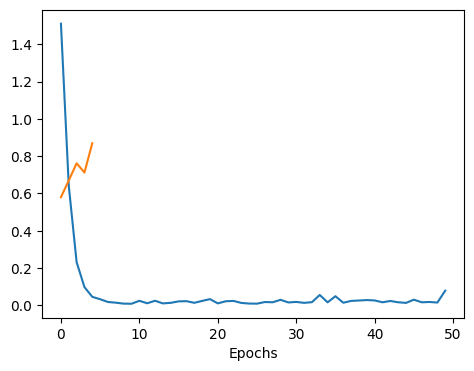

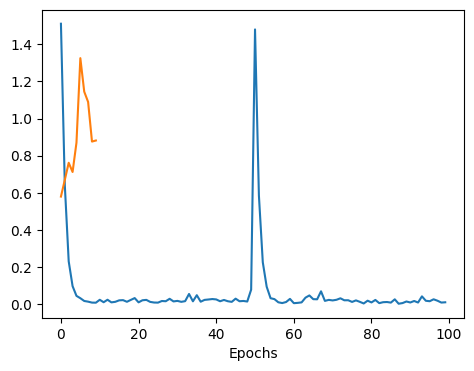

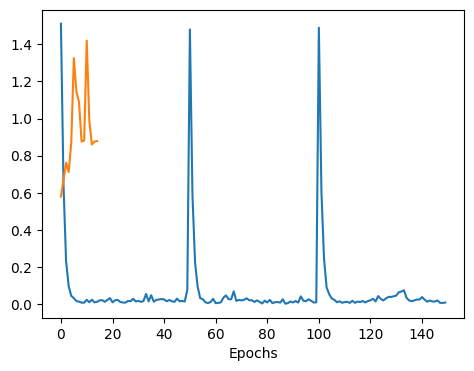

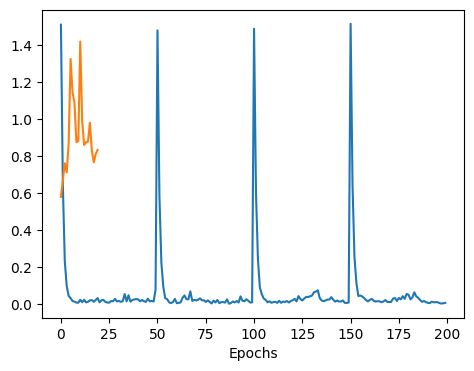

In [4]:
# Lists to store metrics for plotting
train_losses = []
val_losses = []
accuracies = []

# Training loop for each fold
for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(dataset.samples, dataset.targets)):
    print(f"Training Fold {fold + 1}/{n_splits}")

    # Create data loaders for the current fold
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=264, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=264, sampler=val_sampler)

    print(len(train_loader), len(val_loader))

    # Define the EfficientNet model
    model = models.efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(1280, len(dataset.classes))

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Move the model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Training loop
    num_epochs = 50

    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = total_correct / total_samples
        train_losses.append(train_loss)

        # Validation
        if epoch % 10 == 9:  # Print results every 10 epochs
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                correct = 0
                total = 0
                all_predicted = []
                all_labels = []

                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    all_predicted.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                val_losses.append(val_loss / len(val_loader))
                accuracy = correct / total
                accuracies.append(accuracy)

                # Calculate precision, recall, and F1 score
                precision = precision_score(all_labels, all_predicted, average='weighted')
                recall = recall_score(all_labels, all_predicted, average='weighted')
                f1 = f1_score(all_labels, all_predicted, average='weighted')

                print(f'Fold: {fold + 1}, Epoch {epoch + 1}/{num_epochs}, '
                      f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                      f'Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {accuracy:.4f}, '
                      f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

    # # Plotting loss and accuracy curves
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.plot(train_losses, label='Train Loss')
    # plt.plot(val_losses, label='Validation Loss')
    # plt.xlabel('Epochs')
    # plt


In [5]:
# Lists to store metrics for plotting
train_losses = []
val_losses = []
accuracies = []

# Training loop for each fold
for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(dataset.samples, dataset.targets)):
    print(f"Training Fold {fold + 1}/{n_splits}")

    # Create data loaders for the current fold
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(dataset, batch_size=264, sampler=train_sampler)
    val_loader = DataLoader(dataset, batch_size=264, sampler=val_sampler)

    print(len(train_loader), len(val_loader))

    # Define the EfficientNet model
    model = models.efficientnet_b0(pretrained=False)
    model.classifier[1] = nn.Linear(1280, len(dataset.classes))

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Move the model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Training loop
    num_epochs = 50

    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = total_correct / total_samples
        train_losses.append(train_loss)

        # Validation
        if epoch % 10 == 9:  # Print results every 10 epochs
            model.eval()
            with torch.no_grad():
                val_loss = 0.0
                correct = 0
                total = 0
                all_predicted = []
                all_labels = []

                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)

                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    all_predicted.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

                val_losses.append(val_loss / len(val_loader))
                accuracy = correct / total
                accuracies.append(accuracy)

                # Calculate precision, recall, and F1 score
                precision = precision_score(all_labels, all_predicted, average='weighted')
                recall = recall_score(all_labels, all_predicted, average='weighted')
                f1 = f1_score(all_labels, all_predicted, average='weighted')

                print(f'Fold: {fold + 1}, Epoch {epoch + 1}/{num_epochs}, '
                      f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
                      f'Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {accuracy:.4f}, '
                      f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')

    # # Plotting loss and accuracy curves
    # plt.figure(figsize=(12, 4))
    # plt.subplot(1, 2, 1)
    # plt.plot(train_losses, label='Train Loss')
    # plt.plot(val_losses, label='Validation Loss')
    # plt.xlabel('Epochs')
    # plt


Training Fold 1/4
3 1


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold: 1, Epoch 10/50, Train Loss: 0.4166, Train Accuracy: 0.8703, Val Loss: 1.8112, Val Accuracy: 0.1396, Precision: 0.0195, Recall: 0.1396, F1 Score: 0.0342


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold: 1, Epoch 20/50, Train Loss: 0.1392, Train Accuracy: 0.9668, Val Loss: 2.3661, Val Accuracy: 0.2973, Precision: 0.1051, Recall: 0.2973, F1 Score: 0.1552
Fold: 1, Epoch 30/50, Train Loss: 0.0839, Train Accuracy: 0.9653, Val Loss: 1.6899, Val Accuracy: 0.6306, Precision: 0.6548, Recall: 0.6306, F1 Score: 0.6347
Fold: 1, Epoch 40/50, Train Loss: 0.0479, Train Accuracy: 0.9804, Val Loss: 1.9013, Val Accuracy: 0.6306, Precision: 0.6589, Recall: 0.6306, F1 Score: 0.6342
Fold: 1, Epoch 50/50, Train Loss: 0.0589, Train Accuracy: 0.9819, Val Loss: 2.0851, Val Accuracy: 0.6486, Precision: 0.6736, Recall: 0.6486, F1 Score: 0.6475
Training Fold 2/4
3 1


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold: 2, Epoch 10/50, Train Loss: 0.4943, Train Accuracy: 0.8283, Val Loss: 1.7347, Val Accuracy: 0.2353, Precision: 0.0554, Recall: 0.2353, F1 Score: 0.0896


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold: 2, Epoch 20/50, Train Loss: 0.1606, Train Accuracy: 0.9593, Val Loss: 2.1957, Val Accuracy: 0.2715, Precision: 0.2238, Recall: 0.2715, F1 Score: 0.1627
Fold: 2, Epoch 30/50, Train Loss: 0.1058, Train Accuracy: 0.9684, Val Loss: 1.7714, Val Accuracy: 0.5928, Precision: 0.5979, Recall: 0.5928, F1 Score: 0.5843
Fold: 2, Epoch 40/50, Train Loss: 0.0493, Train Accuracy: 0.9804, Val Loss: 1.8936, Val Accuracy: 0.6561, Precision: 0.6606, Recall: 0.6561, F1 Score: 0.6521
Fold: 2, Epoch 50/50, Train Loss: 0.0730, Train Accuracy: 0.9789, Val Loss: 2.3633, Val Accuracy: 0.6425, Precision: 0.6600, Recall: 0.6425, F1 Score: 0.6378
Training Fold 3/4
3 1


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold: 3, Epoch 10/50, Train Loss: 0.5052, Train Accuracy: 0.8554, Val Loss: 1.7650, Val Accuracy: 0.2353, Precision: 0.0554, Recall: 0.2353, F1 Score: 0.0896


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold: 3, Epoch 20/50, Train Loss: 0.1116, Train Accuracy: 0.9563, Val Loss: 1.9889, Val Accuracy: 0.2534, Precision: 0.1072, Recall: 0.2534, F1 Score: 0.1336
Fold: 3, Epoch 30/50, Train Loss: 0.1286, Train Accuracy: 0.9654, Val Loss: 1.4922, Val Accuracy: 0.6833, Precision: 0.6927, Recall: 0.6833, F1 Score: 0.6793
Fold: 3, Epoch 40/50, Train Loss: 0.0806, Train Accuracy: 0.9789, Val Loss: 1.6694, Val Accuracy: 0.6652, Precision: 0.6698, Recall: 0.6652, F1 Score: 0.6668
Fold: 3, Epoch 50/50, Train Loss: 0.0347, Train Accuracy: 0.9895, Val Loss: 1.8729, Val Accuracy: 0.6380, Precision: 0.6688, Recall: 0.6380, F1 Score: 0.6351
Training Fold 4/4
3 1


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold: 4, Epoch 10/50, Train Loss: 0.3993, Train Accuracy: 0.8931, Val Loss: 1.8437, Val Accuracy: 0.2308, Precision: 0.0533, Recall: 0.2308, F1 Score: 0.0865


/home/rishabh.mondal/miniconda3/envs/torch_space/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fold: 4, Epoch 20/50, Train Loss: 0.1257, Train Accuracy: 0.9654, Val Loss: 1.9941, Val Accuracy: 0.2805, Precision: 0.1822, Recall: 0.2805, F1 Score: 0.1661
Fold: 4, Epoch 30/50, Train Loss: 0.0767, Train Accuracy: 0.9744, Val Loss: 1.7758, Val Accuracy: 0.6561, Precision: 0.6613, Recall: 0.6561, F1 Score: 0.6528
Fold: 4, Epoch 40/50, Train Loss: 0.0811, Train Accuracy: 0.9684, Val Loss: 1.9057, Val Accuracy: 0.6380, Precision: 0.6374, Recall: 0.6380, F1 Score: 0.6352
Fold: 4, Epoch 50/50, Train Loss: 0.0756, Train Accuracy: 0.9759, Val Loss: 1.8233, Val Accuracy: 0.6697, Precision: 0.6763, Recall: 0.6697, F1 Score: 0.6645
